In [1]:
%load_ext autoreload
%autoreload 2
%aimport -jax
%aimport -jaxlib

In [2]:
from stanza.runtime import setup
setup()

import jax
import jax.numpy as jnp
from jax.random import PRNGKey
from stanza.random import PRNGSequence

In [47]:
from typing import Any
from stanza.data import PyTreeData
from stanza.dataclasses import dataclass
from scipy.special import binom
from stanza.diffusion.ddpm import DDPMSchedule


Cond = Any
Value = Any

@dataclass
class Sample:
    cond: Cond
    value: Value


log_gaussian_kernel = lambda x: jnp.sum(-jnp.square(x))/2 - jnp.log(jnp.sqrt(2*jnp.pi))

def nadaraya_watson(samples, kernel, h):
    def estimator(cond):
        kernel_smoothing = lambda x, xi: kernel((x-xi)/h)
        log_smoothed = jax.vmap(kernel_smoothing, in_axes=[None, 0])(cond, samples.cond)
        log_total = jax.scipy.special.logsumexp(log_smoothed)
        log_smoothed = log_smoothed - log_total
        smoothed = jnp.exp(log_smoothed)
        return Sample(cond=jnp.array([cond]), value=jnp.sum(smoothed*samples.value, axis=0))
    return estimator

def nw_cond_diffuser(data, schedule, kernel, h):
    def diffuser(cond, noised_value, t):
        sqrt_alphas_prod = jnp.sqrt(schedule.alphas_cumprod[t])
        one_minus_alphas_prod = 1 - schedule.alphas_cumprod[t]
        def comb_kernel(sample):
            x, y_hat_diff = sample.cond, sample.value
            x = jax.tree_map(lambda x: x/h, x)
            # Use one_minus_alphas_prod as the kernel bandwidth for the noised value
            y_diff = jax.tree_map(lambda x: x/one_minus_alphas_prod, y_hat_diff)
            return kernel(x) + log_gaussian_kernel(y_diff)
        x, y = data.cond, data.value
        y_hat = jax.tree_map(lambda x: x*sqrt_alphas_prod, y)
        estimator_data = Sample(cond=x,value=y_hat), y
        estimator = nadaraya_watson(estimator_data, comb_kernel, h)
        return estimator(jnp.concatenate([jnp.array([cond]), noised_value]))
    return diffuser

def nw_diffusion(rng_key, samples, schedule, cond_kernel, noised_value_kernel, 
                              h_cond, h_noised, num_noised_samples):

    def estimator(cond, noised_value, t):
        add_noise = lambda rng, sample, t : (sample.cond, sample.value, schedule.add_noise(rng, sample.value, t)[0])
        batch_add_noise = lambda rng, sample, t: jax.vmap(add_noise, in_axes=(0, None, None))(
            jax.random.split(rng, num_noised_samples), sample, t
        ) 
        noised_samples = jax.vmap(batch_add_noise, in_axes=(0,0,None))(
            jax.random.split(rng_key, samples.cond.shape[0]),
            samples,
            t
        )
        conds = jnp.reshape(noised_samples[0], (-1, samples.cond.shape[-1]))
        values = jnp.reshape(noised_samples[1], (-1, samples.value.shape[-1]))
        noised_values = jnp.reshape(noised_samples[2], (-1, samples.value.shape[-1]))

        cond_K = lambda x, xi: cond_kernel((x-xi)/h_cond)
        noised_value_K = lambda x, xi: noised_value_kernel((x-xi)/h_noised)
        # exact form if kernel is gaussian:
        # value_sigma = 1 - schedule.alphas_cumprod[t]
        # value_K = lambda x, xi: value_kernel((x-xi)/value_sigma)

        log_prob = (
            jax.vmap(cond_K, in_axes=[None, 0])(cond, conds) + 
            jax.vmap(noised_value_K, in_axes=[None, 0])(noised_value, noised_values)
        )
        log_allcond_total = jax.scipy.special.logsumexp(log_prob)
        log_smoothed = log_prob - log_allcond_total
        smoothed = jnp.exp(log_smoothed)
        return Sample(cond=jnp.array([cond]), value=jnp.sum(smoothed[:,None]*values, axis=0))
    
    return estimator

def nw_diffusion_local_poly(rng_key, samples, schedule, degree, cond_kernel, noised_value_kernel, 
                                        h_cond, h_noised, num_noised_samples):

    def estimator(cond, noised_value, t):
        add_noise = lambda rng, sample, t : (sample.cond, sample.value, schedule.add_noise(rng, sample.value, t)[0])
        batch_add_noise = lambda rng, sample, t: jax.vmap(add_noise, in_axes=(0, None, None))(
            jax.random.split(rng, num_noised_samples), sample, t
        ) 
        noised_samples = jax.vmap(batch_add_noise, in_axes=(0,0,None))(
            jax.random.split(rng_key, samples.cond.shape[0]),
            samples,
            t
        )
        conds = jnp.reshape(noised_samples[0], (-1, samples.cond.shape[-1]))
        values = jnp.reshape(noised_samples[1], (-1, samples.value.shape[-1]))
        noised_values = jnp.reshape(noised_samples[2], (-1, samples.value.shape[-1]))

        x_samples = jnp.concatenate((conds, noised_values), -1)
        x = jnp.concatenate((jnp.array([[cond]]), jnp.array([noised_value])), -1)
        
        cond_K = lambda x, xi: cond_kernel((x-xi)/h_cond)
        noised_value_K = lambda x, xi: noised_value_kernel((x-xi)/h_noised)

        log_prob = (
            jax.vmap(cond_K, in_axes=[None, 0])(cond, conds) + 
            jax.vmap(noised_value_K, in_axes=[None, 0])(noised_value, noised_values)
        )
        prob = jax.nn.softmax(log_prob)[:,None]

        # poly = PolynomialFeatures(degree)
        # num_poly_features = binom(degree + x_samples.shape[-1], x_samples.shape[-1]).astype(int)
        # poly_x_samples_shape = jax.ShapeDtypeStruct(
        #     [*x_samples.shape[:-1], num_poly_features], 
        #     x_samples.dtype
        # )
        # poly_x_shape = jax.ShapeDtypeStruct(
        #     [*x.shape[:-1], num_poly_features], 
        #     x.dtype
        # )
        # poly_x_samples = jax.pure_callback(poly.fit_transform, poly_x_samples_shape, x_samples)
        # poly_x = jax.pure_callback(poly.fit_transform, poly_x_shape, x)

        poly_x_samples = expand_poly_features(degree, x_samples)
        poly_x = expand_poly_features(degree, x)

        # M =   jnp.sqrt(prob) * poly_x_samples
        # b = jnp.sqrt(prob) * values
        # coeffs, _, _, _ = jnp.linalg.lstsq(M, b)

        M = poly_x_samples.T @ (prob * poly_x_samples)
        b = poly_x_samples.T @ (prob * values)
        # jax.debug.print('{s}', s=M)
        # jax.debug.print('{s}', s=b)
        coeffs, _, _, _ = jnp.linalg.lstsq(M, b)
        #jax.debug.print('{s}', s=coeffs.shape)

        estimate = jnp.dot(poly_x, coeffs)
        
        return Sample(cond=jnp.array([cond]), value=estimate[0,:])
    
    return estimator

def expand_poly_features(degree, samples):
    # Adapted from sklearn.preprocessing.PolynomialFeatures
    num_features = samples.shape[-1]
    num_poly_features = binom(degree + samples.shape[-1], samples.shape[-1]).astype(int)
    poly_samples = jnp.empty((samples.shape[0], num_poly_features))
    poly_samples = poly_samples.at[:, 0].set(1)
    if degree >= 1:
        poly_samples = poly_samples.at[:, 1:1+num_features].set(samples)
    if degree >= 2:
        index = list(range(1, 1+num_features))
        current_col = 1 + num_features 
        index.append(current_col)
        for _ in range(2, degree + 1):
            new_index = []
            end = index[-1]
            for feature_idx in range(num_features):
                start = index[feature_idx]
                new_index.append(current_col)
                next_col = current_col + end - start
                if next_col <= current_col:
                    break
                # XP[:, start:end] are terms of degree d - 1
                # that exclude feature #feature_idx.
                poly_samples = poly_samples.at[:, current_col:next_col].set(
                    poly_samples[:, start:end] * samples[:, feature_idx : feature_idx + 1]
                )
                current_col = next_col

            new_index.append(current_col)
            index = new_index
    return poly_samples



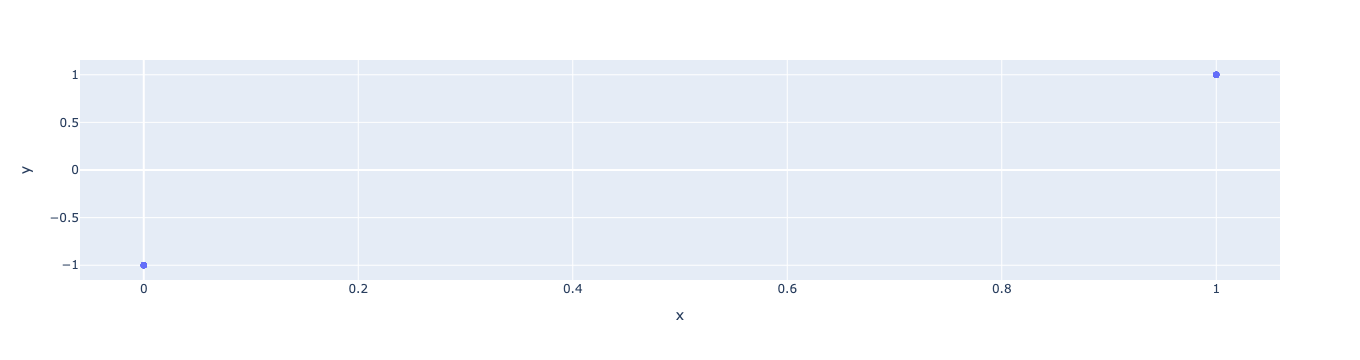

In [43]:
num_samples = 64
rng_key = PRNGKey(42)
dim = 1
w = 1
shift = 0

a = -jnp.ones((dim,)) / jnp.sqrt(dim)
b = jnp.ones((dim,)) / jnp.sqrt(dim)
deltas = jnp.stack([a, b])
conds = jnp.array([0, shift, 1-shift, 1])
p = jnp.array([[1,0],[w,1-w],[1-w,w],[0,1]])

def generate(rng_key, conds, p):
    i_rng, j_rng = jax.random.split(rng_key, 2)
    i = jax.random.choice(i_rng, conds.shape[0])
    j = jax.random.choice(j_rng, 2, p=p[i,:])
    return Sample(cond=jnp.array([conds[i]]), value=jnp.array(deltas[j]))
data = jax.vmap(generate, in_axes=(0, None, None))(
        jax.random.split(rng_key, num_samples), conds, p)
#print(data)

data_sample = data.value[0]
def plot_data_scatter(samples, value_transform=lambda x: x):
    import plotly.express as px
    conds = samples.cond
    values = samples.value
    values = jax.vmap(value_transform)(values)
    # conds = jax.tree_map(
    #     lambda x: jnp.repeat(
    #         x[:, None, ...],
    #         values.shape[-1],
    #         axis=1
    #     ), conds
    # )
    x, y = jax.tree_util.tree_map(
        lambda x: jnp.reshape(x, (-1,)),
        (conds, values)
    )
    px.scatter(x=x, y=y, opacity=0.5).show()

proj_transform = lambda x: jnp.dot(x, jnp.ones((data_sample.shape[-1],))/jnp.sqrt(data_sample.shape[-1]))
plot_data_scatter(data, proj_transform)

# samples = jax.vmap(nw_estimator)(jnp.linspace(0,1,32))
# print(samples)
# plot_samples_scatter(samples)




In [8]:
from jax.scipy.special import factorial

def comb(n, k):
    '''
    Returns n choose k.
    '''
    return factorial(n) / (factorial(n-k) * factorial(k))

def factorial2(n):
    '''
    Computes (n)!!, where n is an odd integer.
    '''
    n_half = (n-1)/2
    return factorial(n) / (factorial(n_half) * jnp.power(2,n_half))

def gaussian_moments(degree, mean, var):
    '''
    Returns an array of length degree, where the ith element is
    E[X^i] for X ~ N(mean, var). 
    '''
    moments = jnp.empty(degree+1)
    moments = moments.at[0].set(1)
    if degree >= 1:
        moments = moments.at[1].set(mean)
    for i in range(2, degree+1):
        moments = moments.at[i].set(mean * moments[i-1] + (i-1) * var * moments[i-2])
    return moments

def central_gaussian_moments(degree, var):
    '''
    Returns an array of length degree, where the ith element is
    E[X^i] for X ~ N(0, var). 
    '''
    moments = jnp.empty(degree+1)
    moments = moments.at[0].set(1)
    compute_even_moment = lambda p: jnp.pow(var, p//2) * factorial2(p-1)
    even_moments = jax.vmap(compute_even_moment)(2*jnp.arange(1,degree//2 + 1))
    moments = moments.at[2*jnp.arange(1,degree//2+1)].set(even_moments)
    return moments


In [9]:
# d=1 case
def make_psi(degree, var, h):
    def psi(cond):
        sigma = jnp.sqrt(var)
        sigh = var + h*h
        K = jnp.exp(-cond*cond * (1-var/sigh) / (2*h*h)) / jnp.sqrt(2*jnp.pi*sigh)
        mu = sigma * cond / sigh
        new_var = h*h / sigh
        moments = gaussian_moments(degree, mu, new_var)
        poly_cond = jnp.flip(expand_poly_features(degree, jnp.array([[cond]])))
        poly_sigma = expand_poly_features(degree, jnp.array([[sigma]]))
        binom_coeffs = jax.vmap(comb, in_axes=(None, 0))(degree, jnp.arange(degree+1))
        signs = jax.vmap(jnp.power, in_axes=(None, 0))(-1, jnp.arange(degree+1))
        # print(moments)
        # print(poly_cond)
        # print(binom_coeffs)
        # print(signs)
        return K * jnp.sum(binom_coeffs * signs * moments * poly_cond * poly_sigma, axis=-1)
    return psi

psi = make_psi(3, 2, 4)
#print(psi(1))
print(jax.vmap(psi)(jnp.linspace(0,1,10)))

[[0.        ]
 [0.04960466]
 [0.0996501 ]
 [0.15057378]
 [0.20280635]
 [0.25676858]
 [0.3128678 ]
 [0.37149525]
 [0.43302268]
 [0.49779946]]


In [10]:
# sample version, d=1
def make_psi_sample(degree, var, h):
    def psi(cond):
        sigma = jnp.sqrt(var)
        def sample_fn(rng):
            w_sample = jax.random.normal(rng)
            arg = cond - sigma*w_sample
            return jnp.power(arg, degree) * jnp.exp(-arg*arg/(2*h*h)) / (jnp.sqrt(2*jnp.pi) * h)
        return jnp.mean(jax.vmap(sample_fn)(jax.random.split(PRNGKey(42), 256)))
    return psi

psi_sample = make_psi_sample(3,2,4)
print(jax.vmap(psi_sample)(jnp.linspace(0,1,10)))

[-0.01054519  0.04026778  0.09170805  0.14420232  0.19816943  0.2540169
  0.31213796  0.37290847  0.436684    0.50379723]


In [11]:
from scipy.special import binom
from functools import partial
# general d
def make_psi_multi(degrees, Sigma, H):
    '''
    degrees: shape (d,) vector corresponding to [j_1,...,j_d]
    Sigma: shape (d,) vector of noise variances
    H: shape (d,) vector of bandwidth variances
    Returns the function psi.
    '''
    def psi(cond):
        dim = Sigma.shape[-1]
        Sigma_sqrt = jnp.sqrt(Sigma)
        Hinv = jnp.ones_like(H)/H
        M = Sigma * Hinv + jnp.ones_like(Sigma)
        Minv = jnp.ones_like(M)/M
        c = Hinv * Sigma_sqrt * cond
        K = jnp.power(2*jnp.pi, -dim/2) * jnp.sqrt( jnp.prod(Minv) * jnp.prod(Hinv)) \
            * jnp.exp(-0.5*(cond.T @ (Hinv * cond) - c.T @ (Minv * c)))  
        z = cond - Sigma_sqrt * Minv * c

        def exp_monomial(z, sigma, var, degree):
            # moments = central_gaussian_moments(degree, var)
            # poly_z = jnp.flip(expand_poly_features(degree, jnp.array([[z]])))
            # poly_sigma = expand_poly_features(degree, jnp.array([[sigma]]))
            # binom_coeffs = jax.vmap(comb, in_axes=(None, 0))(degree, jnp.arange(degree+1))
            # signs = jax.vmap(jnp.power, in_axes=(None, 0))(-1, jnp.arange(degree+1))
            # return jnp.sum(binom_coeffs * signs * moments * poly_z * poly_sigma, axis=-1)

            def body_fn(i, carry):
                i = 2*i
                # moment = jnp.pow(var, i//2) * factorial2(i-1) 
                # poly_z = jnp.pow(z, degree-i)
                # poly_sigma = jnp.pow(sigma, i)
                # binom_coeff = comb(degree, i)
                # return carry + moment * binom_coeff * poly_z * poly_sigma
                log_moment = (i//2) * jnp.log(var) + jnp.log(factorial2(i-1))
                poly_z = jnp.pow(z, degree-i)
                log_poly_sigma = i*jnp.log(sigma)
                log_binom_coeff = jnp.log(comb(degree, i))
                return carry + jnp.exp(log_moment + log_binom_coeff + log_poly_sigma) * poly_z
            result = jnp.pow(z, degree) + jax.lax.fori_loop(1, (degree//2).astype(int) + 1, body_fn, 0)
            return result
        
        prod_monomials = 1
        for i in range(dim):
            prod_monomials *= exp_monomial(z[i], Sigma[i], Minv[i], degrees[i])
        return K * prod_monomials
    
    return psi

# psi_multi = make_psi_multi(jnp.array([1]), jnp.array([1]), jnp.array([1]))
# print(psi_multi(jnp.array([1])))

# psi_multi = make_psi_multi(jnp.array([1]), jnp.array([1]), jnp.array([4]))
# print(psi_multi(jnp.array([2])))

psi_multi = make_psi_multi(jnp.array([2,1]), jnp.array([1,1]), jnp.array([1,4]))
print(psi_multi(jnp.array([1,2])))

0.03152896


In [12]:
# sample version, general d

def make_psi_sample_multi(degrees, Sigma, H):
    def psi(cond):
        Sigma_sqrt = jnp.sqrt(Sigma)
        def sample_fn(rng):
            w_sample = jax.random.normal(rng, cond.shape)
            arg = cond - Sigma_sqrt * w_sample
            log_gaussian_kernel = lambda x, H: jnp.sum(-jnp.square(x)/(2*H) - jnp.log(jnp.sqrt(2*jnp.pi*H)))
            # print(jnp.power(arg, degrees))
            # print(jnp.exp(log_gaussian_kernel(arg,H)))
            return jnp.prod(jnp.power(arg, degrees)) * jnp.exp(log_gaussian_kernel(arg, H))
        return jnp.mean(jax.vmap(sample_fn)(jax.random.split(PRNGKey(42), 2048)))
    return psi

# psi_sample_multi = make_psi_sample_multi(jnp.array([1]), jnp.array([1]), jnp.array([1]))
# print(psi_sample_multi(jnp.array([1])))

# psi_sample_multi = make_psi_sample_multi(jnp.array([1]), jnp.array([1]), jnp.array([4]))
# print(psi_sample_multi(jnp.array([2])))

psi_sample_multi = make_psi_sample_multi(jnp.array([2,1]), jnp.array([1,1]), jnp.array([1,4]))
print(psi_sample_multi(jnp.array([1,2])))

0.031761188


In [13]:
def enumerate_degrees(num_features, degree):
    '''
    Returns an array of shape (num_features,) vectors of nonnegative integers,
    each summing to at most `degree`.
    '''
    num_poly_features = binom(degree + num_features, num_features).astype(int)
    degree_vecs = jnp.empty((num_poly_features, num_features))
    degree_vecs = degree_vecs.at[0, :].set(jnp.zeros((num_features,)))

    features = jnp.eye(num_features)

    if degree >= 1:
        degree_vecs = degree_vecs.at[1:1+num_features, :].set(features)

    if degree >= 2:
        index = list(range(1, 1+num_features))
        current_row = 1 + num_features
        index.append(current_row)

        for _ in range(2, degree + 1):
            new_index = []
            end = index[-1]

            for feature_idx in range(num_features):
                start = index[feature_idx]
                new_index.append(current_row)
                next_row = current_row + end - start
                if next_row <= current_row:
                    break
                # XP[:, start:end] are terms of degree d - 1
                # that exclude feature #feature_idx.
                degree_vecs = degree_vecs.at[current_row:next_row, :].set(
                    degree_vecs[start:end, :] + features[feature_idx : feature_idx + 1, :]
                )
                current_row = next_row

            new_index.append(current_row)
            index = new_index

    return degree_vecs

print(enumerate_degrees(3,3))

[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [2. 0. 0.]
 [1. 1. 0.]
 [1. 0. 1.]
 [0. 2. 0.]
 [0. 1. 1.]
 [0. 0. 2.]
 [3. 0. 0.]
 [2. 1. 0.]
 [2. 0. 1.]
 [1. 2. 0.]
 [1. 1. 1.]
 [1. 0. 2.]
 [0. 3. 0.]
 [0. 2. 1.]
 [0. 1. 2.]
 [0. 0. 3.]]


In [14]:
def nw_diffusion_local_poly_closed(samples, schedule, degree, H):

    def estimator(cond, noised_value, t):
        x = jnp.concatenate((jnp.array([[cond]]), jnp.array([noised_value])), -1)
        alphas_prod = schedule.alphas_cumprod[t]
        x_samples = jnp.concatenate((samples.cond, jnp.sqrt(alphas_prod)*samples.value), -1)
        num_features = x.shape[-1]
        Sigma = jnp.zeros((samples.cond.shape[-1],))
        Sigma = jnp.append(
            Sigma,
            jnp.repeat(jnp.array([1-alphas_prod]), samples.value.shape[-1])
        )
        #jax.debug.print('{s}', s=Sigma)

        degree_vecs = enumerate_degrees(num_features, degree)

        # such that: degree_matrix[i, j, :] = degree_vecs[i, :] + degree_vecs[j, :]
        degree_matrix = degree_vecs[None, :, :] + degree_vecs[:, None, :]
        apply_psi = lambda deg_vec: jnp.sum(
            jax.vmap(make_psi_multi(deg_vec, Sigma, H))(x_samples - x),
            axis=0
        )
        A = jax.vmap(jax.vmap(apply_psi))(degree_matrix)

        
        apply_psi = lambda deg_vec: jnp.sum(
            jax.vmap(make_psi_multi(deg_vec, Sigma, H))(x_samples - x)[:, None] * samples.value,
            axis=0
        )
        b = jax.vmap(apply_psi)(degree_vecs)

        # jax.debug.print('{s}', s=A)
        # jax.debug.print('{s}', s=b)
        coeffs, _, _, _ = jnp.linalg.lstsq(A, b)

        poly_x = expand_poly_features(degree, x)
        estimate = jnp.dot(poly_x, coeffs)

        # jax.debug.print('{s}', s=estimate.shape)
        
        return Sample(cond=jnp.array([cond]), value=estimate[0,:])
    
    return estimator

In [15]:
from stanza.diffusion.ddpm import DDPMSchedule
schedule = DDPMSchedule.make_squaredcos_cap_v2(50, clip_sample_range=3.0, prediction_type="sample")

#nw_estimator = nadaraya_watson_diffusion(PRNGKey(42), data, schedule, log_gaussian_kernel, log_gaussian_kernel, 0.1, 0.1, 10)
#nw_estimator(0, jnp.array([0]), 0)
#plot_samples_scatter(jax.vmap(nw_estimator, in_axes=(0, None, None))(jnp.linspace(0,1,32), jnp.array([-1]), 0))
#nw_estimator = nw_diffusion_local_poly_closed(data, schedule, 1, 0.04*jnp.ones((data.cond.shape[-1] + data.value.shape[-1],)))
nw_estimator = nw_diffusion_local_poly(PRNGKey(42), data, schedule, 1, log_gaussian_kernel, log_gaussian_kernel,
                                                   0.01, 0.01, 64)
#print(nw_estimator(1,jnp.array([0,0,0,0]),0))

def sample_values(rng_key, cond, num_samples):
    model = lambda _, y_t, t: nw_estimator(cond, y_t, t).value
    batch_sample_fn = jax.vmap(schedule.sample, in_axes=(0, None, None))
    sampled_y_pred = batch_sample_fn(jax.random.split(rng_key, num_samples), model, data_sample)
    return Sample(jnp.array([cond]), sampled_y_pred)

def compute_denoised():
    denoiser = lambda cond, y_t, t: nw_estimator(cond, y_t, t).value
    conds = jnp.array([0, 0.5, 1])
    xs = jnp.linspace(0, 1, 10) 
    ts = jnp.arange(1, schedule.num_steps + 1)
    Conds, Xs, Ts = jnp.meshgrid(conds, xs, ts, indexing='ij')
    Xs = Xs[...,None] * jnp.ones((data_sample.shape[-1],))/jnp.sqrt(data_sample.shape[-1])[None,...]
    values = jax.vmap(jax.vmap(jax.vmap(denoiser)))(Conds, Xs, Ts)
    return conds, xs, ts, values

def plot_score(conds, xs, ts, values, value_transform=lambda x:x):
    import plotly.express as px
    import plotly.graph_objects as go
    ret = {}
    Xs, Ts = jnp.meshgrid(xs, ts)
    Xs = Xs.reshape(-1)
    Ts = Ts.reshape(-1)
    for cond, values in zip(conds, values):
        values = jax.vmap(value_transform)(values)
        #ret = ret | {str(cond.item()): px.scatter_3d(x=Xs, y=Ts, z=values.reshape(-1), opacity=0.5)}
        ret = ret | {str(cond.item()): go.Figure(data=[go.Surface(x=ts, y=xs, z=values)])}
    return ret

# denoised = compute_denoised()
# plots = plot_score(*denoised, proj_transform)
# for plot in plots.values():
#     plot.show(renderer="browser")

num_conds = 32
num_samples = 64
samples = jax.vmap(sample_values, in_axes=[0,0,None])(
    jax.random.split(PRNGKey(42), num_conds),
    jnp.linspace(0,1,num_conds),
    num_samples
)
#print(samples)


/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:6: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).

/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:13: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).



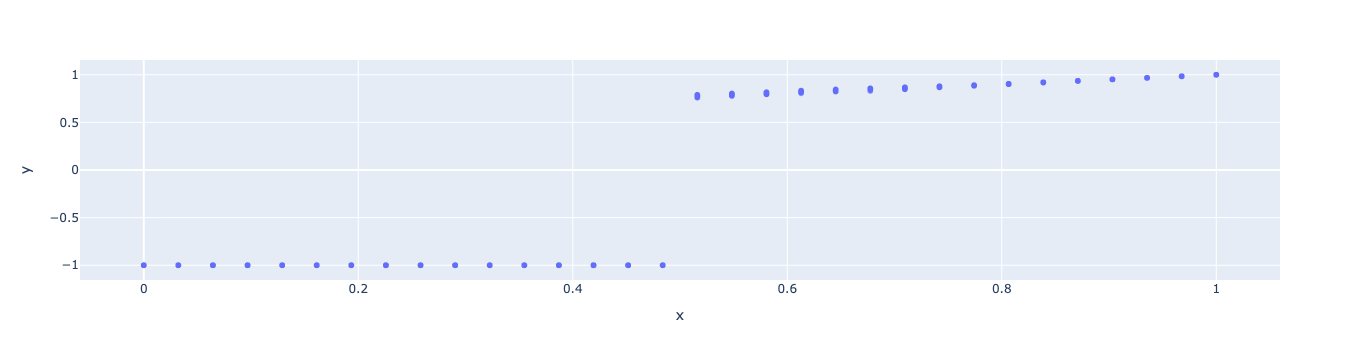

In [16]:
def plot_samples_scatter(samples, value_transform=lambda x: x):
    import plotly.express as px
    conds = samples.cond
    values = samples.value
    values = jax.vmap(value_transform)(values)
    conds = jax.tree_util.tree_map(
        lambda x: jnp.repeat(
            x[:, None, ...],
            values.shape[1],
            axis=1
        ), conds
    )
    x, y = jax.tree_util.tree_map(
        lambda x: jnp.reshape(x, (-1,)),
        (conds, values)
    )
    px.scatter(x=x, y=y, opacity=0.5).show()
plot_samples_scatter(samples, proj_transform)

/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:6: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).

/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:13: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).



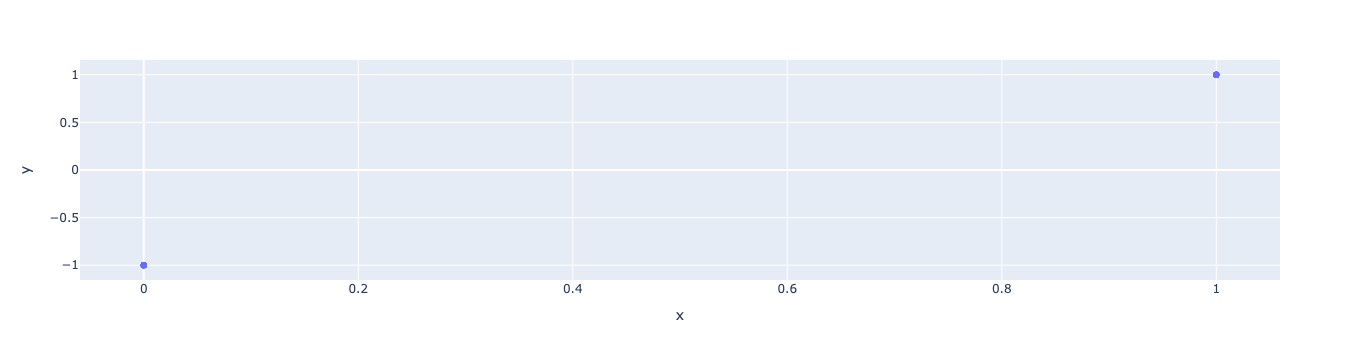

In [17]:
nw_estimator = nw_diffusion_local_poly_closed(data, schedule, 1, 0.01*jnp.ones((data.cond.shape[-1] + data.value.shape[-1],)))
plot_samples_scatter(jax.vmap(nw_estimator, in_axes=(0,0,None))(data.cond[:,0], data.value, 1))

In [18]:
test_data = Sample(cond=jnp.array([[1],[-1]]), value=jnp.array([[0.5],[-1]]))
nw_estimator = nw_diffusion_local_poly_closed(test_data, schedule, 2, 0.01*jnp.ones((test_data.cond.shape[-1] + test_data.value.shape[-1],)))
plot_samples_scatter(jax.vmap(nw_estimator, in_axes=(0,0,None))(test_data.cond[:,0], test_data.value, 1))

/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:6: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).

/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:13: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).



/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:6: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).

/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:13: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).



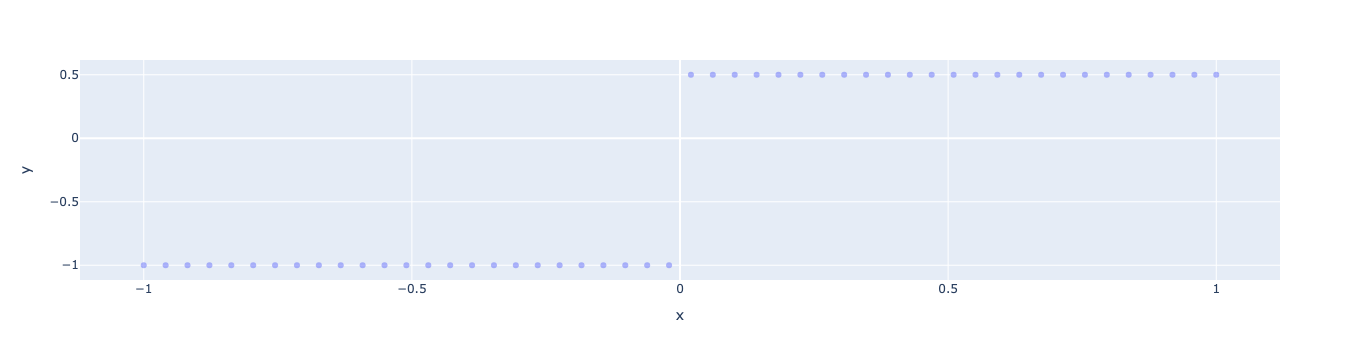

In [37]:
nw_estimator_sampler = nw_diffusion_local_poly(PRNGKey(42), test_data, schedule, 0, log_gaussian_kernel, log_gaussian_kernel,
                                                    0.01, 0.01, 64)
plot_samples_scatter(jax.vmap(nw_estimator_sampler, in_axes=(0,None,None))(jnp.linspace(-1, 1, 50), test_data.value[0], 50))

In [46]:
nw_estimator_0 = nw_cond_diffuser(data, schedule, log_gaussian_kernel, 0.01)
plot_samples_scatter(jax.vmap(nw_estimator_0, in_axes=(0,None,None))(jnp.linspace(-1, 1, 50), test_data.value[0], 50))

/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/2138516300.py:40: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).



ValueError: Zero-dimensional arrays cannot be concatenated.

In [20]:
nw_estimator_sampler = nw_diffusion_local_poly(PRNGKey(42), data, schedule, 1, log_gaussian_kernel, log_gaussian_kernel,
                                                    1, 1, 64)
plot_samples_scatter(jax.vmap(nw_estimator_sampler, in_axes=(0,0,None))(data.cond[:,0], data.value, 1))

/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:6: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).

/var/folders/24/7j6t10xd1n3551j10gb0jkwm0000gn/T/ipykernel_92261/590808656.py:13: DeprecationWarning:

jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).

